In [1]:
%load_ext watermark
%watermark

Last updated: 2022-12-03T20:36:20.752435-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.7.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np

import pandas as pd

import cv2

from PIL import Image

import os

from io import BytesIO

import base64

from IPython.display import HTML

from gtts import gTTS

import pytesseract

from progressbar import ProgressBar

from concurrent.futures import ThreadPoolExecutor

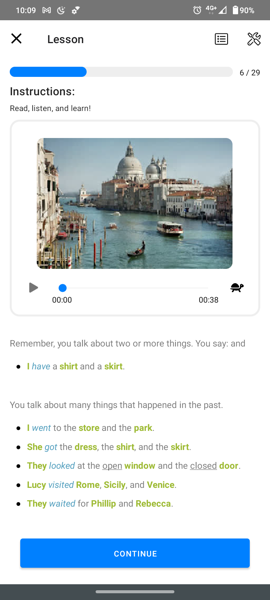

In [3]:
# path = '_resources/img/blank.png'
path = '_resources/img/Screenshot_20210528-100908.png'

img = Image.open(path)
img.thumbnail((300, 600))
img

In [4]:
def image_to_string(path):
    img = cv2.imread(path)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray, img_bin = cv2.threshold(gray, 128, 255,
                                  cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    gray = cv2.bitwise_not(img_bin)

    kernel = np.ones((2, 1), np.uint8)
    img = cv2.erode(gray, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)

    return pytesseract.image_to_string(img)


image_to_string(path)

'vw 90%\nx Lesson ws\nGD 6/29\nInstructions:\nRead, listen, and learnt\n> e Eg\n\n00:00 00:38\n\nRemember, you talk about two or more things. You say: and\n\ne [havea shirt and a skirt.\n\nYou talk about many things that happened in the past.\n\ne | went to the store and the park.\n\nShe got the dress, the shirt, and the skirt.\n\nThey fooked at the open window and the closed door.\n\nLucy visited Rome, Sicily, and Venice.\n\nThey waited for Phillip and Rebecca.\n\nCONTINUE\n'

''
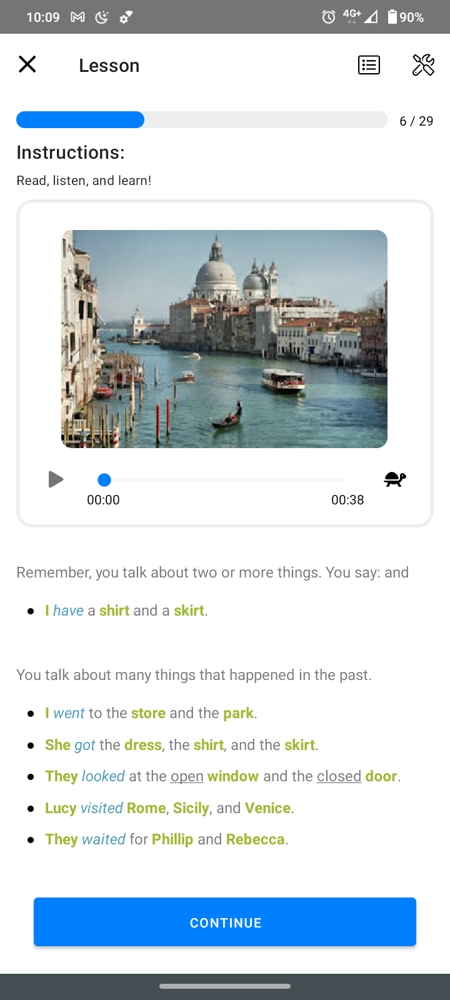

In [5]:
def b64encode(path):
    img = Image.open(path)
    img.thumbnail((600, 1000))

    with BytesIO() as buffer:
        img.save(buffer, 'png')
        img_encode = base64.b64encode(buffer.getvalue()).decode()

    return f'<img src="data:image/png;base64,{img_encode}">'


b64encode(path)

Se obtienen los textos a partir de las imágenes.

In [6]:
raw_text_df = pd.DataFrame(columns=['name', 'image', 'text'])
raw_text_df.set_index(keys='name', inplace=True)

img_path = os.listdir('_resources/img')[:5]

bar = ProgressBar(maxval=len(img_path)).start()
i = 0


def gen_string(name):
    path = f'_resources/img/{name}'

    img = b64encode(path)
    text = image_to_string(path)

    name = name.split('.')[0]
    raw_text_df.loc[name] = [img, text]

    global i
    i += 1
    bar.update(i)


# max_workers=1 para que se ejecute en el mismo orden
with ThreadPoolExecutor(max_workers=1) as executor:
    futures = [executor.submit(gen_string, name)
               for name in img_path if name != 'desktop.ini']

bar.finish()

raw_text_df.reset_index(inplace=True)
raw_text_df.head(10)

100% |########################################################################|


,name,image,text
0,Screenshot_20210528-100908,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",vw 90%\nx Lesson ws\nGD 6/29\nInstructions:\nR...
1,Screenshot_20210528-100918,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",10:09 ™ @ 4s 90%\nx Lesson x\nGD 8/29\n\nInstr...
2,Screenshot_20210528-100924,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Pa @ 4A fho0%\nx Lesson ws\n\nD> 10/29\n\nInst...
3,Screenshot_20210528-101214,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Pd 90%\nx Lesson Ss\nD> 12/29\nInstructions:\n...


,name,image,text
0,Screenshot_20210528-100908,,"vw 90%\nx Lesson ws\nGD 6/29\nInstructions:\nRead, listen, and learnt\n> e Eg\n\n00:00 00:38\n\nRemember, you talk about two or more things. You say: and\n\ne [havea shirt and a skirt.\n\nYou talk about many things that happened in the past.\n\ne | went to the store and the park.\n\nShe got the dress, the shirt, and the skirt.\n\nThey fooked at the open window and the closed door.\n\nLucy visited Rome, Sicily, and Venice.\n\nThey waited for Phillip and Rebecca.\n\nCONTINUE\n"
1,Screenshot_20210528-100918,,"10:09 ™ @ 4s 90%\nx Lesson x\nGD 8/29\n\nInstructions:\n\nRead, listen, and learn!\n\n00:00 00:30\n\nYou talk about things that happened and didnt happen in the\npast.\n\ne They /ooked at the open window, but not the door.\ne | visited Rome, but not Venice.\n\ne We waited for Phillip, but not Rebecca.\n\ne You ta/ked to Olivia, but not her mother.\n\ne She walked to work, but not home.\n\ne@ He saw the boots, but not the hat.\n\nNow you try!\n\nCONTINUE\n"
2,Screenshot_20210528-100924,,"Pa @ 4A fho0%\nx Lesson ws\n\nD> 10/29\n\nInstructions:\n\nRead, listen, and learn!\n\n¥\n\n>»\n\n00:00 00:35\n\nYou talk about many things that happened in the past.\n\ne Iwrote a letter, watched a movie, and went to the store\nyesterday.\n\ne She danced at the club, traveled to the city, and played a\ngame last week.\n\nYou talk about things that happened and did not happen. You\nsay:\n\ne Larrived in Los Angeles and bought a shirt, but did not go\nto the market.\n\ne He danced with Renee and ate a sandwich, but did not\ndrink the water.\n\nCONTINUE\n"
3,Screenshot_20210528-101214,,"Pd 90%\nx Lesson Ss\nD> 12/29\nInstructions:\nRead, listen, and learn!\n> @ cg\n00:00 00:39\n\nYou talk about things that happened in the past. You say:\n\ne She went to the park and the supermarket.\n\ne She atc cake and went to the market.\n\nYou talk about things that happened and didn't happen in the\npast. You say:\n\ne I talked to the doctor and the teacher, but not the student.\n\ne He ate the fruit and the chips, but cicin't drink the soda.\n\nNow you try!\n\nCONTINUE\n"

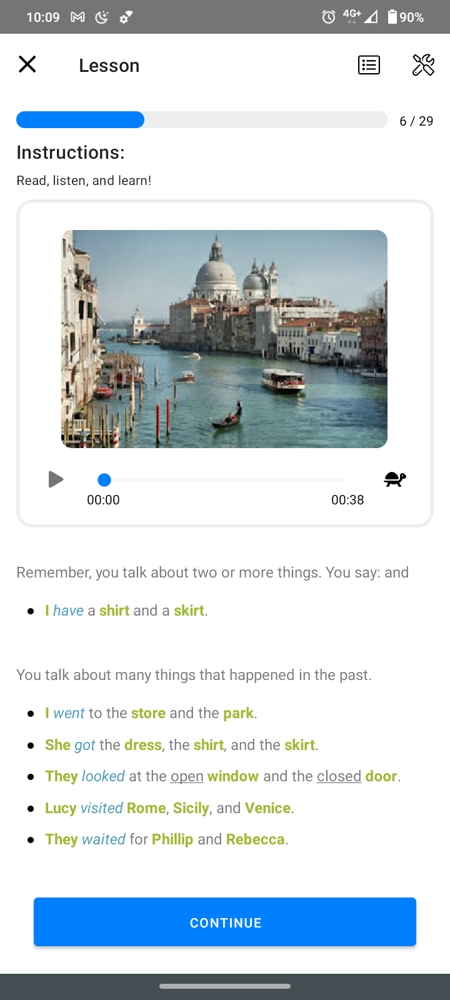
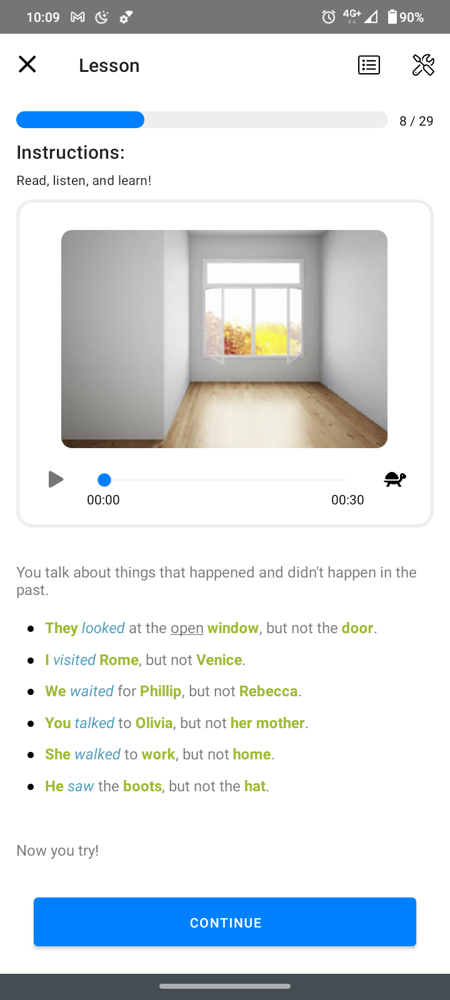
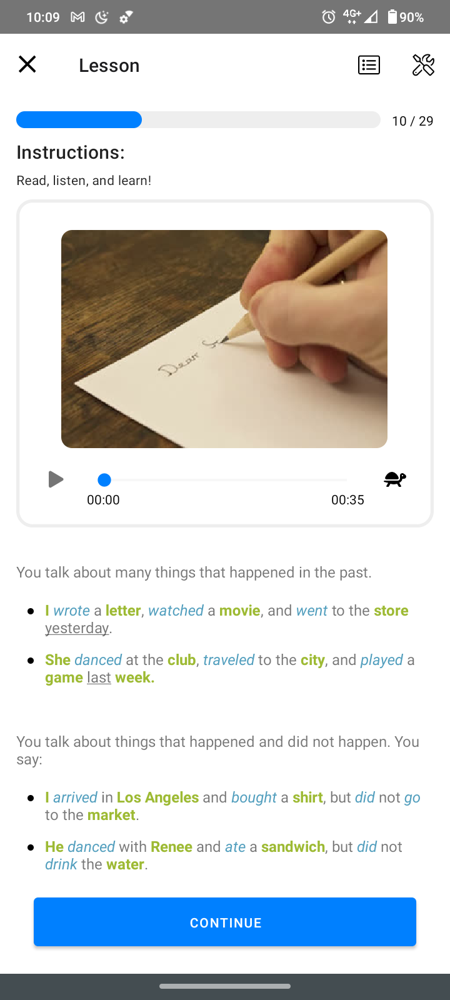
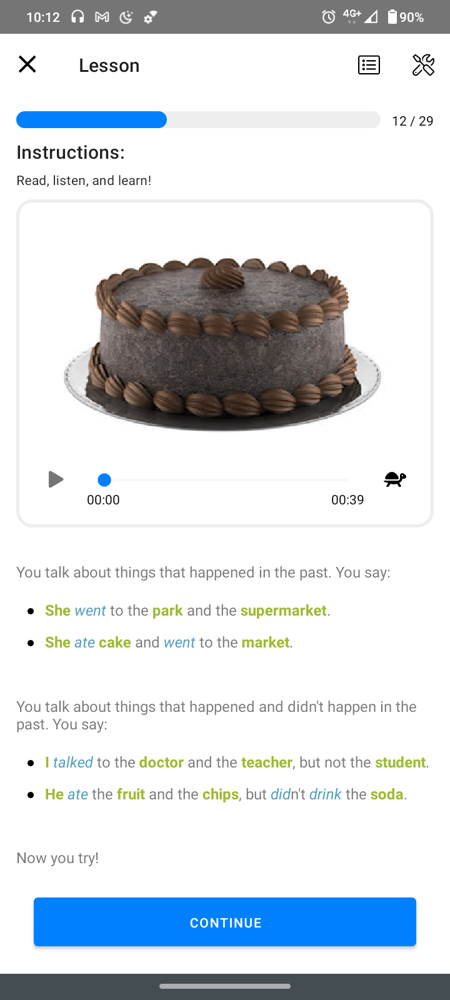

In [7]:
html_string = raw_text_df.to_html(escape=False)
HTML(html_string)

In [8]:
with open('_resources/raw_data.html', 'w') as file:
    file.write(html_string)

- Se debe hacer una copia del html guardado anteriormente (`raw_data.html`).
- Se debe editar el html copiado (`data.html`).

Se carga el html editado.

In [9]:
df = pd.read_html('_resources/data.html')[0][['name', 'text']]
df.head(10)

,name,text
0,Screenshot_20210528-100908,vw 90%\nx Lesson ws\nGD 6/29\nInstructions:\nR...
1,Screenshot_20210528-100918,10:09  @ 4s 90%\nx Lesson x\nGD 8/29\n\nInstr...
2,Screenshot_20210528-100924,Pa @ 4A fho0%\nx Lesson ws\n\nD> 10/29\n\nInst...
3,Screenshot_20210528-101214,Pd 90%\nx Lesson Ss\nD> 12/29\nInstructions:\n...
4,Screenshot_20210528-103610,vw 88%\nx Lesson ws\nGD 8/29\nInstructions:\nR...
5,Screenshot_20210528-103849,Pa 88%\nx Lesson as\n\nD> 10/28\n\nInstruction...
6,Screenshot_20210528-104141,10:41\n\nx Lesson as\n\nSD 12/29\n\nInstructio...
7,Screenshot_20210530-161202,88%\n\nxX Lesson =] X&\n\nGD 6/29\n\nInstructi...
8,Screenshot_20210530-161416,"GD 8/29\n\nInstructions:\n\nRead, listen, and ..."


Se generan los audios a partir de los textos.

In [10]:
%%script echo Descomentar para ejecutar la celda

bar = ProgressBar(maxval=df.shape[0]).start()
i = 0


def save_audio(name, text):
    path = f'_resources/audio/{name}.mp3'

    try:
        if os.path.exists(path) == True:
            raise ValueError()

        gtts = gTTS(text=text, lang='en', slow=False)
        gtts.save(path)
    except ValueError:
        pass
    except Exception as e:
        #         print(e)
        os.remove(path)
    finally:
        global i
        i += 1
        bar.update(i)


# max_workers=1 para que no nos de denegación de servicio
with ThreadPoolExecutor(max_workers=1) as executor:
    futures = [executor.submit(save_audio, e[0], e[1])
               for e in df.to_numpy()]

    executor.shutdown(wait=True)

bar.finish()

Couldn't find program: 'echo'
